In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# -----------------------------
# Utilities: unfold_kv (same as earlier)
# -----------------------------
def unfold_kv(x: torch.Tensor, kernel_size: int, padding: int = 0):
    """
    x: (B, H, T, D)
    returns: (B, H, T, kernel_size, D)
    """
    B, H, T, D = x.shape
    x_img = x.permute(0, 1, 3, 2).reshape(B * H, D, 1, T)
    x_unf = F.unfold(x_img, kernel_size=(1, kernel_size), padding=(0, padding), stride=(1, 1))
    x_unf = x_unf.view(B * H, D, kernel_size, T)
    x_unf = x_unf.permute(0, 3, 2, 1).reshape(B, H, T, kernel_size, D)
    return x_unf

# -----------------------------
# RoPE helpers
# -----------------------------
def build_rope_cache(seq_len: int, dim: int, device=None, dtype=torch.float32):
    """
    Build cos and sin caches for RoPE.
    Returns:
      cos: (seq_len, dim//2)
      sin: (seq_len, dim//2)
    Note: dim must be even (we treat pairs).
    """
    assert dim % 2 == 0, "RoPE head dim must be even"
    half = dim // 2
    inv_freq = 1.0 / (10000 ** (torch.arange(0, half, dtype=dtype, device=device) / half))
    positions = torch.arange(seq_len, dtype=dtype, device=device).unsqueeze(1)  # (seq_len,1)
    angles = positions * inv_freq.unsqueeze(0)  # (seq_len, half)
    cos = torch.cos(angles)  # (seq_len, half)
    sin = torch.sin(angles)
    return cos, sin

def apply_rope_to_qk(x: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor):
    """
    x: (B, H, T, D) where D is even
    cos, sin: (T, D//2)
    returns rotated x of same shape
    """
    B, H, T, D = x.shape
    half = D // 2
    # Split interleaved: even/odd positions along last dim
    x1 = x[..., :D:2]  # (B,H,T,half)
    x2 = x[..., 1:D:2]  # (B,H,T,half)
    # cos/sin -> (1,1,T,half) for broadcasting
    cos_b = cos.unsqueeze(0).unsqueeze(0)  # (1,1,T,half)
    sin_b = sin.unsqueeze(0).unsqueeze(0)
    # rotate
    x1c = x1 * cos_b - x2 * sin_b
    x2c = x1 * sin_b + x2 * cos_b
    # interleave back: [x1c0, x2c0, x1c1, x2c1, ...]
    x_rot = torch.stack([x1c, x2c], dim=-1).reshape(B, H, T, D)
    return x_rot

# -----------------------------
# Hybrid Sparse Attention with RoPE
# -----------------------------
class RoPEHybridSparseAttention(nn.Module):
    def __init__(self, dim: int, num_heads: int = 8, window: int = 4, dropout: float = 0.0):
        super().__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"
        head_dim = dim // num_heads
        assert head_dim % 2 == 0, "head_dim must be even for RoPE"
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.window = window
        self.kernel_size = 2 * window + 1

        self.q_proj = nn.Linear(dim, dim, bias=False)
        self.k_proj = nn.Linear(dim, dim, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)
        self.out_proj = nn.Linear(dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)

        # caches for RoPE will be created on forward based on seq_len

    def forward(self, x: torch.Tensor, global_mask: torch.Tensor = None):
        """
        x: (B, T, D)
        global_mask: (B, T) bool
        returns: out (B, T, D), full_attn (B, H, T, T)  # full_attn is for visualization
        """
        B, T, D = x.shape
        device = x.device
        # 1) project
        q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B,H,T,dh)
        k = self.k_proj(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.v_proj(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # 1.5) build RoPE cache and apply to q,k
        cos, sin = build_rope_cache(T, self.head_dim, device=device, dtype=q.dtype)  # (T, dh/2)
        q = apply_rope_to_qk(q, cos, sin)
        k = apply_rope_to_qk(k, cos, sin)

        # 2) extract local windows
        K_windows = unfold_kv(k, kernel_size=self.kernel_size, padding=self.window)  # (B,H,T,win,dh)
        V_windows = unfold_kv(v, kernel_size=self.kernel_size, padding=self.window)  # (B,H,T,win,dh)

        # 3) local scores
        scores_local = torch.einsum("bhtd,bhtwd->bhtw", q, K_windows) / (self.head_dim ** 0.5)  # (B,H,T,win)

        # 4) global part
        if global_mask is None:
            scores_global = None
            K_global = None
            V_global = None
            global_idx_list = [torch.empty(0, dtype=torch.long, device=device) for _ in range(B)]
            global_token_mask = None
        else:
            global_idx_list = []
            maxG = 0
            for b in range(B):
                idx = torch.nonzero(global_mask[b], as_tuple=False).squeeze(-1)
                if idx.numel() == 0:
                    idx = torch.empty(0, dtype=torch.long, device=device)
                global_idx_list.append(idx)
                if idx.numel() > maxG:
                    maxG = idx.numel()

            if maxG == 0:
                scores_global = None
                K_global = None
                V_global = None
                global_token_mask = None
            else:
                # pad to maxG
                K_global = torch.zeros(B, self.num_heads, maxG, self.head_dim, device=device, dtype=q.dtype)
                V_global = torch.zeros(B, self.num_heads, maxG, self.head_dim, device=device, dtype=q.dtype)
                global_token_mask = torch.zeros(B, maxG, dtype=torch.bool, device=device)
                for b in range(B):
                    idx = global_idx_list[b]
                    if idx.numel() == 0:
                        continue
                    kg = k[b, :, idx, :]  # (H, G_b, dh)
                    vg = v[b, :, idx, :]
                    G_b = kg.shape[1]
                    K_global[b, :, :G_b, :] = kg
                    V_global[b, :, :G_b, :] = vg
                    global_token_mask[b, :G_b] = True

                scores_global = torch.einsum("bhtd,bhgd->bhtg", q, K_global) / (self.head_dim ** 0.5)
                # mask padded later

        # 5) combine local and global
        if scores_global is None:
            attn_local = F.softmax(scores_local, dim=-1)
            ctx_local = torch.einsum("bhtw,bhtwd->bhtd", attn_local, V_windows)
            out_heads = ctx_local  # (B,H,T,dh)
            full_attn = torch.zeros(B, self.num_heads, T, T, device=device, dtype=q.dtype)
            # fill local-only full_attn
            for t in range(T):
                left = max(0, t - self.window)
                right = min(T, t + self.window + 1)
                win_len = right - left
                # attn_local[..., t, :win_len] -> place at positions left:right
                full_attn[..., t, left:right] = attn_local[..., t, :win_len]
        else:
            # mask padded global slots
            gmask = global_token_mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,G)
            scores_global = scores_global.masked_fill(~gmask, float("-1e9"))

            scores_cat = torch.cat([scores_local, scores_global], dim=-1)  # (B,H,T, win+G)
            attn_cat = F.softmax(scores_cat, dim=-1)
            attn_cat = self.dropout(attn_cat)

            w_local = attn_cat[..., : self.kernel_size]
            w_global = attn_cat[..., self.kernel_size :]

            ctx_local = torch.einsum("bhtw,bhtwd->bhtd", w_local, V_windows)
            ctx_global = torch.einsum("bhtg,bhgd->bhtd", w_global, V_global)
            out_heads = ctx_local + ctx_global

            # build full_attn for visualization
            full_attn = torch.zeros(B, self.num_heads, T, T, device=device, dtype=q.dtype)
            for b in range(B):
                gidx = global_idx_list[b]
                for t in range(T):
                    left = max(0, t - self.window)
                    right = min(T, t + self.window + 1)
                    win_len = right - left
                    # local part
                    full_attn[b, :, t, left:right] = w_local[b, :, t, :win_len]
                    # global part -> assign per actual indices
                    if gidx.numel() > 0:
                        G_b = gidx.numel()
                        full_attn[b, :, t, gidx] += w_global[b, :, t, :G_b]

        # 6) merge heads & out proj
        out = out_heads.permute(0, 2, 1, 3).contiguous().view(B, T, D)
        out = self.out_proj(out)

        return out, full_attn



out.shape= torch.Size([1, 48, 128])
full_attn.shape= torch.Size([1, 8, 48, 48])


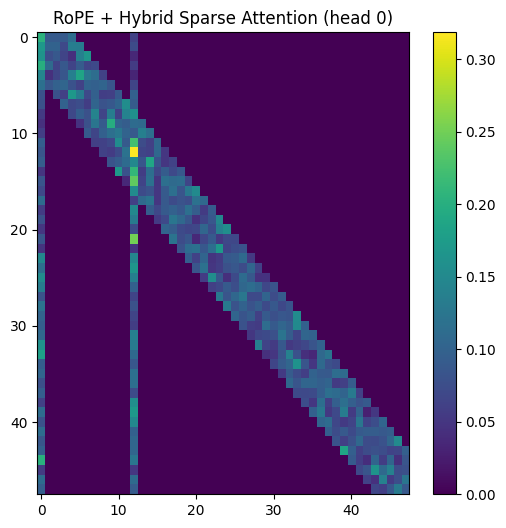

In [3]:
# -----------------------------
# Quick test snippet
# -----------------------------
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    B, T, D = 1, 48, 128
    H = 8
    window = 4
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = RoPEHybridSparseAttention(dim=D, num_heads=H, window=window).to(device)
    x = torch.randn(B, T, D, device=device)

    # set a couple of global tokens
    global_mask = torch.zeros(B, T, dtype=torch.bool, device=device)
    global_mask[0, 0] = True
    global_mask[0, 12] = True

    out, full_attn = model(x, global_mask)
    print("out.shape=", out.shape)            # (B,T,D)
    print("full_attn.shape=", full_attn.shape)  # (B,H,T,T)

    # visualize head 0
    att = full_attn[0, 0].detach().cpu().numpy()  # (T,T)
    plt.figure(figsize=(6,6))
    plt.imshow(att, aspect="auto")
    plt.colorbar()
    plt.title("RoPE + Hybrid Sparse Attention (head 0)")
    plt.show()